# Задача 1. Оценить месячный retention в оформление заказа с помощью когортного анализа.

In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
df_olist_customers = pd.read_csv('olist_customers_dataset.csv')
df_olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_olist_orders = pd.read_csv('olist_orders_dataset.csv')

In [3]:
df_olist_customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
df_olist_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [5]:
df_olist_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [6]:
# Меняем тип данных колонок, отображающих даты на datetime

df_olist_order_items['shipping_limit_date'] = pd.to_datetime(df_olist_order_items['shipping_limit_date'])
df_olist_orders['order_purchase_timestamp'] = pd.to_datetime(df_olist_orders['order_purchase_timestamp'])
df_olist_orders['order_approved_at'] = pd.to_datetime(df_olist_orders['order_approved_at'])
df_olist_orders['order_delivered_carrier_date'] = pd.to_datetime(df_olist_orders['order_delivered_carrier_date'])
df_olist_orders['order_delivered_customer_date'] = pd.to_datetime(df_olist_orders['order_delivered_customer_date'])
df_olist_orders['order_estimated_delivery_date'] = pd.to_datetime(df_olist_orders['order_estimated_delivery_date'])

In [7]:
df_olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [8]:
# Создаем копию данных, чтобы избежать изменений в исходном DataFrame и выбираем заказы, которые не были отменены

df_olist_orders2 = df_olist_orders.query('order_status != "canceled"')

In [9]:
# Объединяем таблицы для того, чтобы получить доступ к уникальному id пользователя

df_olist_orders2 = df_olist_orders2.merge(df_olist_customers, on = 'customer_id')
df_olist_orders2.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


In [10]:
# Извлекаем месяц и день заказа

df_olist_orders2['order_month'] = df_olist_orders2['order_purchase_timestamp'].dt.to_period('M')
df_olist_orders2['order_day'] = df_olist_orders2['order_purchase_timestamp'].dt.to_period('D')

In [11]:
# Присваиваем когорты на основе даты первого действия для каждого пользователя

df_olist_orders2['cohort'] = df_olist_orders2.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
df_olist_orders2['cohort_day'] = df_olist_orders2.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [12]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)

df_olist_orders2['period_number_month'] = np.floor((df_olist_orders2.order_day - df_olist_orders2.cohort_day).apply(attrgetter('n')) / 30)
df_olist_orders2.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_month,order_day,cohort,cohort_day,period_number_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-10-02,2017-09,2017-09-04,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07-24,2018-07,2018-07-24,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08-08,2018-08,2018-08-08,0.0


In [13]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)

df_cohort = df_olist_orders2.groupby(['cohort', 'period_number_month']).agg(customers_num = ('customer_unique_id', 'nunique')).reset_index()
df_cohort.head(3)

,cohort,period_number_month,customers_num
0,2016-09,0.0,2
1,2016-10,0.0,297
2,2016-10,6.0,1


In [14]:
# Создаем сводную таблицу для когортного анализа

cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='customers_num')
cohort_pivot.head(5)

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,297.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,762.0,2.0,NaN,4.0,1.0,1.0,3.0,2.0,NaN,NaN,...,5.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1735.0,3.0,3.0,6.0,4.0,2.0,4.0,2.0,2.0,5.0,...,6.0,2.0,3.0,2.0,1.0,2.0,4.0,NaN,NaN,NaN


In [15]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы) и вычисляем коэффициенты удержания, деля на размер когорты

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003367,NaN,NaN,0.003367,...,0.003367,NaN,0.003367,NaN,0.003367,NaN,0.003367,0.006734,0.003367,0.003367
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002625,NaN,0.005249,0.001312,0.001312,0.003937,0.002625,NaN,NaN,...,0.006562,0.003937,0.002625,NaN,0.002625,0.002625,0.002625,0.001312,NaN,NaN
2017-02,1.0,0.001729,0.001729,0.003458,0.002305,0.001153,0.002305,0.001153,0.001153,0.002882,...,0.003458,0.001153,0.001729,0.001153,0.000576,0.001153,0.002305,NaN,NaN,NaN


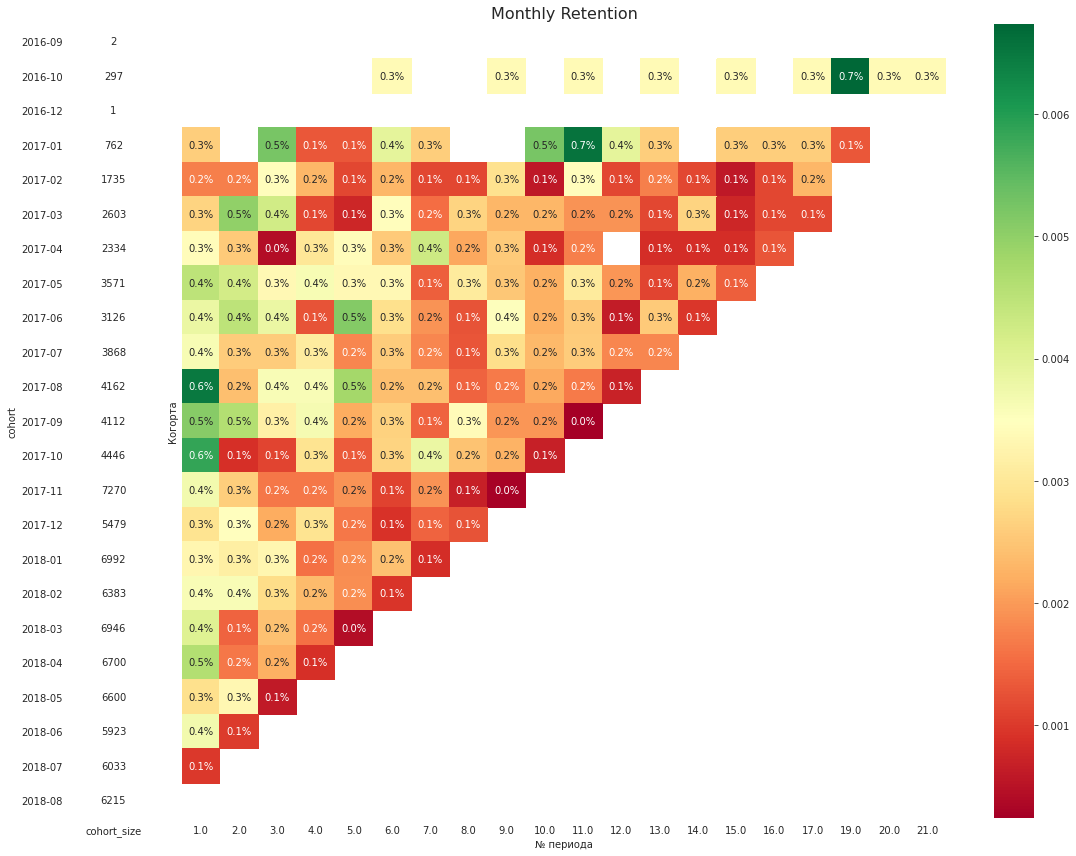

In [16]:
# Строим тепловую карту когортного анализа

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания, убираем период 0, для правильного отображения данных по цветам
    sns.heatmap(retention_matrix.iloc[:, 1:],
                mask=retention_matrix.iloc[:, 1:].isnull(),
                annot=True,
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1]
                )
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0]
               )

    fig.tight_layout()
    plt.show()

In [17]:
# Медианный retention 1-го месяца

retention1 = retention_matrix.iloc[:,1].median()
retention1

0.0036194415718717684

In [18]:
# Когорта с самым высоким retention на 3-й месяц

retention_matrix.iloc[:,3].max()

0.005249343832020997

# Задача 2. Определить, существует ли product/market fit у маркетплейса.

In [19]:
# Преобразуем таблицу в формат, подходящий для графика
# Отбираем 1 часть когорт для лучшего отображения информации

retention = retention_matrix.iloc[:10, 1:].reset_index().melt(
    id_vars = 'cohort',
    var_name = 'day',
    value_name = 'retention'
)

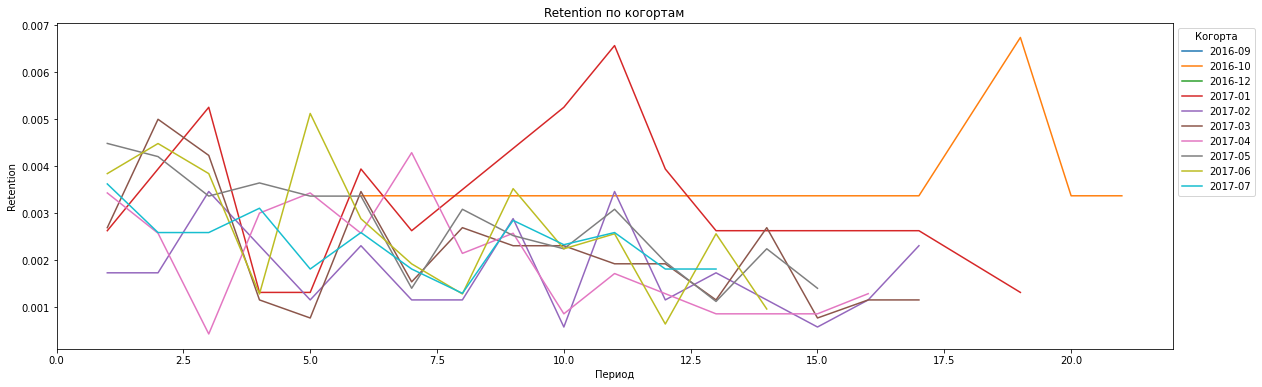

In [20]:
# Устанавливаем размер графика, его цвет и подписи данных
# Строим график lineplot, 1 часть когорт

plt.figure(figsize = (20, 6))
sns.lineplot(data = retention, x = 'day', y = 'retention', hue = 'cohort', palette = 'tab10')

plt.title("Retention по когортам")
plt.xlabel("Период")
plt.ylabel("Retention")
plt.legend(title = 'Когорта', bbox_to_anchor = (1, 1), loc = 'upper left')

In [21]:
# Преобразуем таблицу в формат, подходящий для графика
# Отбираем 2 часть когорт для лучшего отображения информации

retention = retention_matrix.iloc[11:, 1:].reset_index().melt(
    id_vars = 'cohort',
    var_name = 'day',
    value_name = 'retention'
)

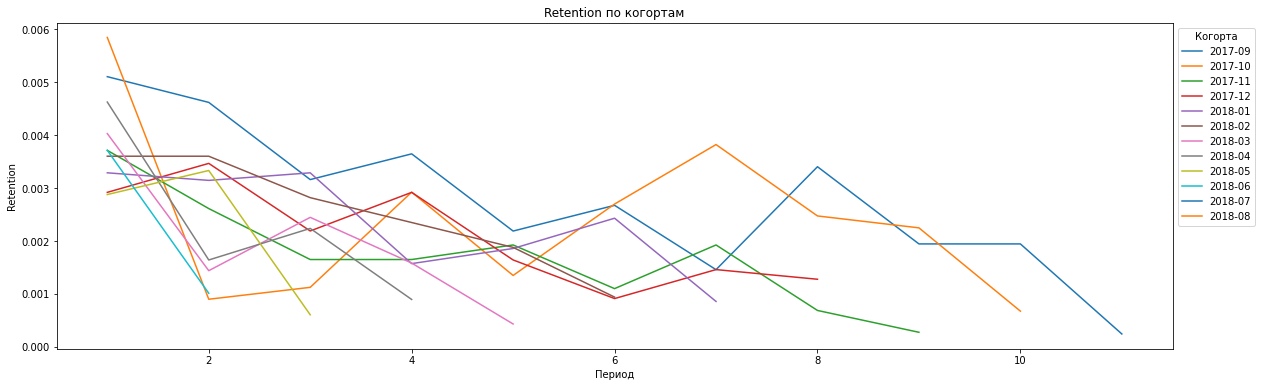

In [22]:
# Устанавливаем размер графика, его цвет и подписи данных
# Строим график lineplot, 2 часть когорт

plt.figure(figsize = (20, 6))
sns.lineplot(data = retention, x = 'day', y = 'retention', hue = 'cohort', palette = 'tab10')

plt.title("Retention по когортам")
plt.xlabel("Период")
plt.ylabel("Retention")
plt.legend(title = 'Когорта', bbox_to_anchor = (1, 1), loc = 'upper left')

На графиках видно, что в большинстве когорт retention стремится к нулю. Из этого можно сделать вывод о том, что продукт не имеет product/market fit.

Возможные причины:
1. Достаточное количество отмен заказа по причине недоступности
2. Задержка доставки заказов
3. Технические проблемы в приложении или на сайте

In [60]:
# Создаем датафрейм и добавляем месяц заказа

df_delay = df_olist_orders
df_delay['month'] = df_olist_orders['order_estimated_delivery_date'].dt.to_period('M')
df_delay["month"] = df_delay["month"].astype(str)

In [61]:
# Создаем колонку, содержащую информацию об отмене

df_delay['delay'] = df_olist_orders['order_delivered_customer_date'] > df_olist_orders['order_estimated_delivery_date']

In [62]:
# Группируем по месяцу и добавляем колонку - процент задержек доставки по месяцам

df_delay = df_delay.groupby('month').agg({'order_id':'count', 'delay':'sum'})
df_delay['delay_percent'] = df_delay['delay']/df_delay['order_id']*100

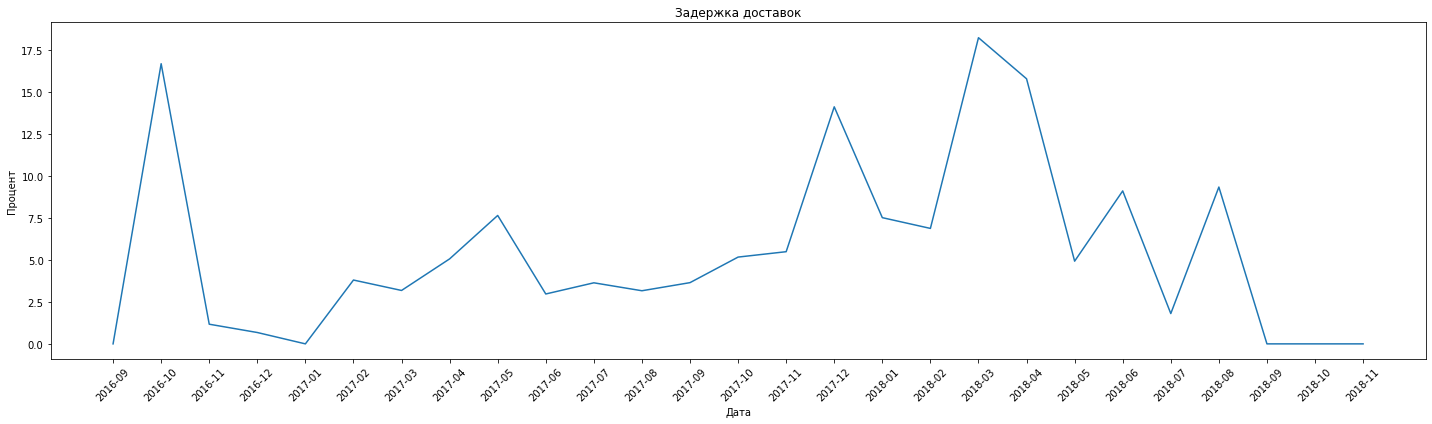

In [65]:
# Строим lineplot, который отображает процент задержек доставок по месяцам
# Добавляем размер, цвет и подписи данных

plt.figure(figsize = (20, 6))
sns.lineplot(data = df_delay, x = 'month', y = 'delay_percent', palette = 'tab10')

plt.title("Задержка доставок")
plt.xlabel("Дата")
plt.ylabel("Процент")
plt.xticks(rotation = 45)
plt.tight_layout()

Задержка заказов происходит стабильно, процент таких лоставок достаточно высокий. Это может влиять на product/market fit.

In [67]:
# Создаем датафрейм и добавляем месяц заказа

df_delay = df_olist_orders
df_delay['month'] = df_olist_orders['order_estimated_delivery_date'].dt.to_period('M')
df_delay["month"] = df_delay["month"].astype(str)

In [70]:
# Выбираем недоставленные заказы для лучшего отображения данных на графике и группируем по месяцу

df_orders = df_olist_orders.query('order_status != "delivered"')
df_orders = df_orders.groupby('order_status', as_index=False).agg({'order_id':'count'})

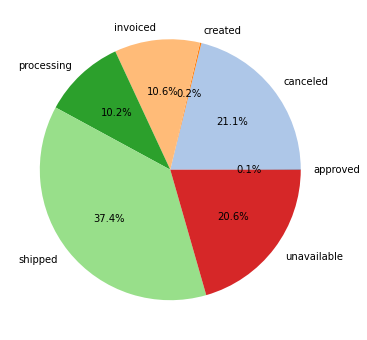

In [79]:
# Строим график pie, который отображает статусы заказов в процентах
# Добавляем размер, цвет и подписи данных

plt.figure(figsize = (10, 6))
colors = sns.color_palette('tab20')

plt.pie(df_orders.order_id, labels=df_orders.order_status, colors=colors, autopct='%.1f%%')
plt.show()

Из недоставленных заказов достаточно большой процент - это отмененные заказы.

# Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Первая метрика должна отражать рост объёма продаж маркетплейса. Такой метрикой может быть revenue (выручка), так как она прямо пропорциональна объёму продаж.

In [29]:
# Выбераем только успешно доставленные заказы

df_delivered_orders = df_olist_orders.query('order_status == "delivered"')

In [30]:
# Объединим таблицы, чтобы получить доступ к стоимости товара

df_order_data = pd.merge(df_delivered_orders, df_olist_order_items, on = "order_id")

In [31]:
# Добавляем колонку "месяц", чтобы разделить продажи по месяцам

df_order_data["order_month"] = df_order_data["order_purchase_timestamp"].dt.to_period("M")

In [32]:
# Считаем revenue по месяцам

monthly_revenue = df_order_data.groupby("order_month", as_index=False).agg({"price":"sum"})
monthly_revenue["order_month"] = monthly_revenue["order_month"].astype(str)

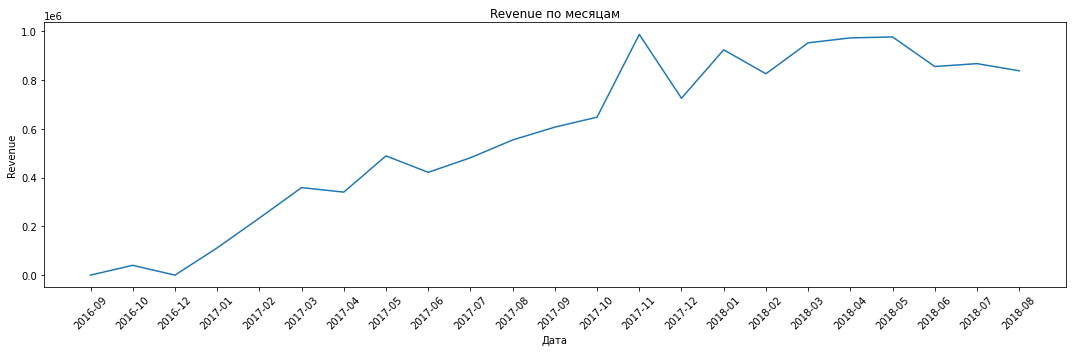

In [33]:
# Устанавливаем размер графика и подписи данных и строим график lineplot

plt.figure(figsize = (15, 5))
sns.lineplot(data = monthly_revenue, x = "order_month", y = "price")
plt.title("Revenue по месяцам")
plt.ylabel("Revenue")
plt.xlabel("Дата")
plt.xticks(rotation = 45)
plt.tight_layout()

На графике видно рост revenue. Из этого можно сделать вывод о том, что объём продаж маркетплейса так же растет.

Вторая метрика должна показывать объем аудитории, которой продукт доставляет ценность. Для этих целей подходит метрика MAU (Monthly Active Users) — количество уникальных пользователей за
месяц.

In [34]:
# Объединим таблицы, чтобы получить доступ к уникальному id пользователя

df_order_data = pd.merge(df_order_data, df_olist_customers, on = "customer_id")

In [35]:
# находим уникальных пользователей по месяцам

mau = df_order_data.groupby("order_month", as_index=False).agg({"customer_unique_id":"nunique"})
mau["order_month"] = mau["order_month"].astype(str)

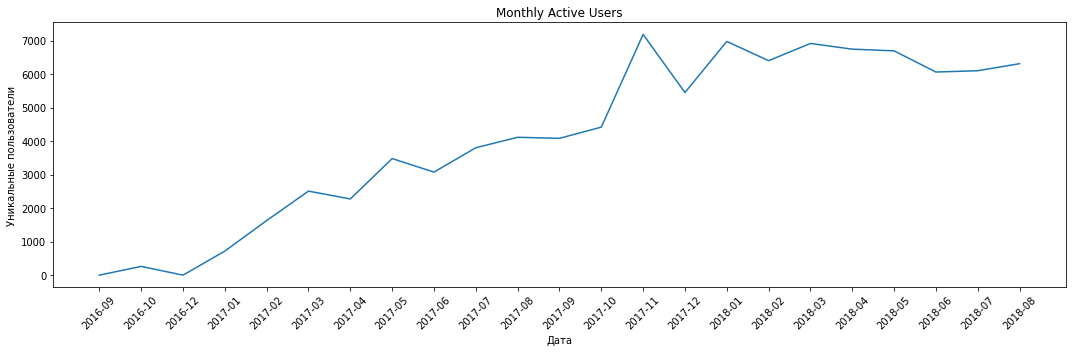

In [36]:
# Устанавливаем размер графика и подписи данных и строим график lineplot

plt.figure(figsize = (15, 5))
sns.lineplot(data = mau, x = "order_month", y = "customer_unique_id")
plt.title("Monthly Active Users")
plt.ylabel("Уникальные пользователи")
plt.xlabel("Дата")
plt.xticks(rotation = 45)
plt.tight_layout()

По графику видно, что метрика MAU растет.

Третья метрика должна отражать заинтересованность новых клиентов в продукте. Для этого можно использовать метрику Time to Value (TTV) — среднее время, которое проходит с момента регистрации пользователя до оформления заказа. 
Информации для построения графика недостаточно, так как необходимо знать время регистрации.

Четвёртая метрика отражает вовлеченность клиента в продолжение использования продукта. Метрика retantion показывает какая доля клиентов вернулась в продукт через определенный период после первого касания.
Графики, отображающие метрику retention, представлены в задаче 2. Вывод из этих графиков - retention стремится к нулю, это значит, что вовлеченность клиента снижается.

Пятая метрика отражает денежное выражение вовлеченности клиента. Для этого возьмем метрику ARPU (average revenue per user) — средний доход на каждого пользователя.

In [37]:
# Вычисляем выручку и количество пользователей по месяцам и находим метрику ARPU

df_revenue_users = df_order_data.groupby("order_month", as_index=False).agg({"price": "sum","customer_unique_id": "nunique"})
df_revenue_users["arpu"] = df_revenue_users["price"] / df_revenue_users["customer_unique_id"]
df_revenue_users["order_month"] = df_revenue_users["order_month"].astype(str)

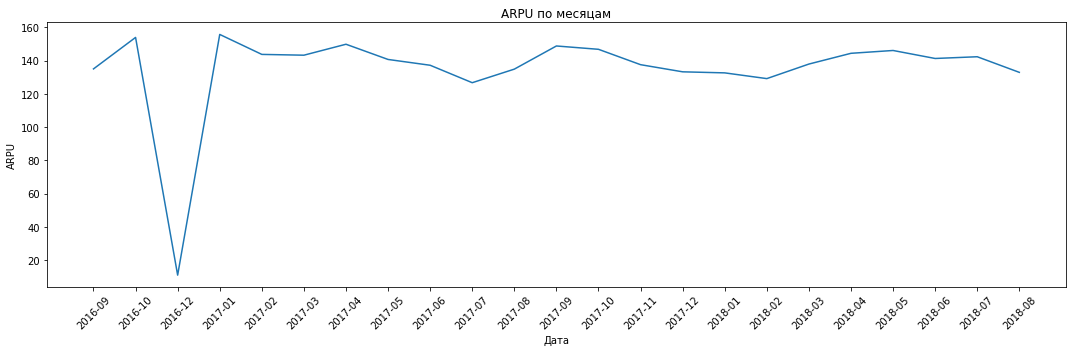

In [38]:
# Устанавливаем размер графика и подписи данных и строим график lineplot

plt.figure(figsize = (15, 5))
sns.lineplot(data = df_revenue_users, x = "order_month", y = "arpu")
plt.title("ARPU по месяцам")
plt.ylabel("ARPU")
plt.xlabel("Дата")
plt.xticks(rotation = 45)
plt.tight_layout()

Из графика можно сделать вывод о том, что метрика ARPU имеет тенденцию к уменьшению.

# Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Гипотеза 1. Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

In [39]:
# Вычислим количество заказов позже июня 2017 года, отменённые по причине недоступности товара

df_olist_orders.query('order_purchase_timestamp >= "2017-06-01" and order_status == "unavailable"').shape

(475, 10)

In [40]:
impact1 = 4

Гипотеза 2. Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 

In [41]:
# Вычислим количество заказов позже июня 2017 года

df_orders = df_olist_orders.query('order_purchase_timestamp >= "2017-06-01"')

In [42]:
# Оставим в таблице заказы, которые были доставлены с задержкой

df_orders['late'] = df_orders['order_delivered_customer_date'] > df_orders['order_estimated_delivery_date']
df_orders = df_orders.query('late == True')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
# Объединим таблицы, чтобы получить доступ к уникальному id пользователя и вычислим их количество

df_order_data = pd.merge(df_orders, df_olist_customers, on = "customer_id")
df_order_data = df_order_data.groupby("customer_unique_id", as_index=False).agg({"order_id": "count"})
df_orders.shape

(7296, 11)

In [44]:
# Вычислим количество пользователей, которые сделают повторный заказ

round(7296 * retention1, 1)

26.4

In [45]:
impact2 = 1

Гипотеза 3. Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ.

In [46]:
# Вычислим количество заказов позже июня 2017 года

df_orders = df_olist_orders.query('order_purchase_timestamp >= "2017-06-01"')

In [47]:
# Объединим таблицы, чтобы получить доступ к уникальному id пользователя и вычислим их количество

df_order_data = pd.merge(df_orders, df_olist_customers, on = "customer_id")
df_order_data = df_order_data.groupby("customer_unique_id", as_index=False).agg({"order_id": "count"})

In [48]:
# Найдем количество пользователей, совершивших 1 заказ

df_order_data.query('order_id == 1').shape

(82559, 2)

In [49]:
# Вычислим количество пользователей, которые сделают повторный заказ

round(82559 * retention1, 1)

298.8

In [50]:
impact3 = 3

Построим фреймворк ICE

In [51]:
# Создадим датафрейм и внесем данные,включая найденные выше

ice = pd.DataFrame([[1, 4, 8, 6],
                  [2, 1, 10, 4],
                  [3, 3, 5, 9]], 
                  columns = ['hypothesis','Impact','Confidence', 'Ease'])

ice = ice.set_index('hypothesis')  

In [52]:
# Расчитаем показатель ICE для каждой гипотезы и отсортируем значения

ice['ICE'] = ice['Impact'] * ice['Confidence'] * ice['Ease']
ice.sort_values('ICE')

,Impact,Confidence,Ease,ICE
hypothesis,,,,
2,1,10,4,40
3,3,5,9,135
1,4,8,6,192


Из готового фреймворка ICE делаем вывод о том, что в приоритете выполнение 1 гипотезы.

# Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

Гипотеза: Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

Целевые метрики:
1. Доля доставленных заказов от всех оформленных - гипотеза направлена на снижение отмен, и на рост успешно доставленных заказов,
2. Lifetime Value - устранение бага должно улучшить лояльность и повторные покупки, соответственно, выручка на клиента должна повыситься.

Прокси метрики:
1. Доля отмен заказов по техническим причинам - данная метрика отражает была ли устранена проблема, она должна ощутимо снизиться.

Guardrail метрики:
1. Доля заказов с задержкой доставки - так как ожидается повышение количества заказов, нужно убедиться, что это не вызовет увеличения количества доставок с задержкой.

# Задача 6. Вот и подошёл к концу ваш первый этап работы аналитиком в команде маркетплейса. Теперь необходимо поделиться результатами проведённой работы с компанией.

Были выявлены следующие проблемы:

1. Retention стремится к нулю, пользователи не возвращаются в продукт после первого заказа (или попытки заказа).

2. Product/market fit отсутствует. На основании метрики поведения (retention) — продукт пока не закрывает потребности рынка.

4. ARPU снижается. Средняя выручка на пользователя падает, что говорит о снижении ценности продукта или ухудшении конверсии в покупки.

5. Значительное количество заказов имеет задержку доставки товаров.

6. Так же значительное количество отмен заказов по техническим проблемам.

Выводы по итогу исследования:

1. Рост MAU и revenue присутствует. Несмотря на отсутствие стабильного удержания, трафик увеличивается и продажи растут.

2. Выбрана приоритетная гипотеза. В приоритете реализация гипотезы об устранении багов в системе обработки заказов, чтобы уменьшить число отмен и увеличить количество успешных доставок.

3. Выбраны целевые, прокси и guardrail метрики для оценки гипотезы.

Рекомендации по продукту:

1. Требуется работа над стратегией удержания пользователей для увеличения повторных заказов.

2. Фокус на улучшении пользовательского опыта оформления заказа.

3. Запустить системный мониторинг метрик отказов и технических ошибок. Нужно отслеживать и сокращать технические сбои, влияющие на отмену заказов.

4. Добавить метрику Time to Value (TTV). В перспективе поможет отслеживать, насколько быстро клиент получает ценность — важно для оптимизации онбординга.